### Dedupe needs more setup therefore a notebook so i can handle it step by Step


In [10]:
import rdflib

ttl_path = "data/healthcare_graph_original_v2.ttl"

def extract_dedupe_fields_from_ttl(ttl_path):
    g = rdflib.Graph()
    g.parse("data/healthcare_graph_original_v2.ttl")
    
    # Map: {entity_type: set([literal_predicate_names])}
    type_predicate_map = {}
    
    for s in set(g.subjects()):
        # Get type
        types = [str(o) for o in g.objects(s, rdflib.RDF.type)]
        if not types:
            continue
        type_ = types[0].split("/")[-1]  # Or use more sophisticated logic if needed
        
        # Gather literal predicates
        predicates = set()
        for p, o in g.predicate_objects(s):
            if isinstance(o, rdflib.Literal):
                pred_name = p.split("/")[-1] if "/" in str(p) else str(p)
                predicates.add(pred_name)
        if type_ not in type_predicate_map:
            type_predicate_map[type_] = set()
        type_predicate_map[type_].update(predicates)
    
    # Build dedupe.io field definitions per entity type
    dedupe_fields = {}
    for type_, preds in type_predicate_map.items():
        dedupe_fields[type_] = [
            {'field': pred, 'type': 'String'} for pred in preds if pred.lower() != "identifier"
]

    return dedupe_fields

fields_per_type = extract_dedupe_fields_from_ttl("data/healthcare_graph_original_v2.ttl")
for entity_type, fields in fields_per_type.items():
    print(f"Entity type: {entity_type}")
    print(fields)
    print()

Entity type: Department
[{'field': 'name', 'type': 'String'}]

Entity type: ContactPoint
[{'field': 'telephone', 'type': 'String'}, {'field': 'faxNumber', 'type': 'String'}, {'field': 'availableLanguage', 'type': 'String'}, {'field': 'contactType', 'type': 'String'}, {'field': 'email', 'type': 'String'}]

Entity type: Person
[{'field': 'jobTitle', 'type': 'String'}, {'field': 'gender', 'type': 'String'}, {'field': 'name', 'type': 'String'}, {'field': 'knowsLanguage', 'type': 'String'}, {'field': 'email', 'type': 'String'}, {'field': 'birthDate', 'type': 'String'}]

Entity type: PostalAddress
[{'field': 'postalCode', 'type': 'String'}, {'field': 'addressLocality', 'type': 'String'}, {'field': 'addressCountry', 'type': 'String'}, {'field': 'streetAddress', 'type': 'String'}]

Entity type: MedicalOrganization
[{'field': 'name', 'type': 'String'}]



In [11]:
from modular_methods.graphToText_utils import kg_to_dedupe_dict
g = rdflib.Graph()
g1 = rdflib.Graph()
g2 = rdflib.Graph()
g.parse("data/healthcare_graph_original_v2.ttl")
g1.parse("data/prog_data/healthcare_graph_progdups.ttl")# sample of the first 15 HCO's
g2.parse("data/train_data/healthcare_graph_replaced_train.ttl")# sample of the other 35 HCO's 
dict1 = kg_to_dedupe_dict(g)
dict2 = kg_to_dedupe_dict(g1)
train_dict = kg_to_dedupe_dict(g2)   

In [12]:
import json
with open("data/dedupe_data/dict1.json", "w") as f:
    json.dump(dict1, f, indent=2)
with open("data/dedupe_data/dict2.json", "w") as f:
    json.dump(dict2, f, indent=2)
with open("data/dedupe_data/train_dict.json", "w") as f:
    json.dump(train_dict, f, indent=2)

## Ground truth for test data

In [13]:
import pandas as pd 
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Replace entity types
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_test = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_test:
        ground_truth_test[key] = []
    ground_truth_test[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

test_GT_Person = ground_truth_test['Person']
test_GT_Address = ground_truth_test['Address']

In [14]:
ground_truth_test

{'Address': [('http://example.org/Address/0e8cff18-9e9d-4b77-ba34-b580eda0a0af',
   'http://example.org/Address/b43baeb2-62b1-4c36-99a2-e67258cf1235'),
  ('http://example.org/Address/1095e497-3d79-4f0b-a6cd-3595d4f0d65d',
   'http://example.org/Address/679dbeb2-2136-402b-811b-c2471abca0b2'),
  ('http://example.org/Address/3899c22a-d4ed-41bd-9692-74a2acbe4ff6',
   'http://example.org/Address/32fd16b8-2e2d-4257-9bd2-e411bfc5e5ce'),
  ('http://example.org/Address/541d1a81-4815-442c-a2bb-62833d83ad7c',
   'http://example.org/Address/a26599c2-c1e3-4595-982d-515d344bbc43'),
  ('http://example.org/Address/603fa8f0-1549-4dee-830b-4d6d9575d095',
   'http://example.org/Address/bd4cf3d7-3c27-4645-99bd-a9a62e2d500a'),
  ('http://example.org/Address/eedbba8b-0f83-41ee-b2ac-89bdb2998fa3',
   'http://example.org/Address/e9b93ff7-1d3c-4297-b080-5fb4cb77938d'),
  ('http://example.org/Address/853a9135-3ee2-451b-be88-c93319db1d7b',
   'http://example.org/Address/fdce7129-5e40-43ea-96e2-a428d9964a8c'),
  

### Perform the manual labelling on train data NOT on test data

In [15]:


golden_standard = pd.read_csv('data/train_data/train_golden_standard_duplicates_final.csv')

# Replace entity types
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_train = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_train:
        ground_truth_train[key] = []
    ground_truth_train[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

# Instead of taking first 50 Person pairs, select 7 per variation type
person_variations = golden_standard_subset_var[
    (golden_standard_subset_var['entity_type'] == 'Person') | 
    (golden_standard_subset_var['entity_type'] == 'HealthcarePersonnel')
]

address_variations = golden_standard_subset_var[
    golden_standard_subset_var['entity_type'] == 'Address']

In [16]:
# Get 7 examples per variation type
GT_Person_by_variation = []
for variation_type in person_variations['variation_type'].unique():
    variation_pairs = person_variations[person_variations['variation_type'] == variation_type]
    
    # Take up to 7 pairs for this variation type
    selected_pairs = variation_pairs.head(20)
    
    for _, row in selected_pairs.iterrows():
        GT_Person_by_variation.append((
            f"http://example.org/Person/{row['original_id']}", 
            f"http://example.org/Person/{row['duplicate_id']}"
        ))

# Replace your existing GT_Person line with:
GT_Person = GT_Person_by_variation

print(f"Total Person pairs selected: {len(GT_Person)}")
print(f"Variation types: {person_variations['variation_type'].unique()}")

# Check distribution
for variation_type in person_variations['variation_type'].unique():
    count = len(person_variations[person_variations['variation_type'] == variation_type].head(20))
    print(f"{variation_type}: {count} pairs")

GT_address_by_variation = []
for variation_type in address_variations['variation_type'].unique():
    variation_pairs = address_variations[address_variations['variation_type'] == variation_type]
    
    # Take up to 7 pairs for this variation type
    selected_pairs = variation_pairs.head(7)
    
    for _, row in selected_pairs.iterrows():
        GT_address_by_variation.append((
            f"http://example.org/Address/{row['original_id']}", 
            f"http://example.org/Address/{row['duplicate_id']}"
        ))
GT_address = GT_address_by_variation
GT_HCO = ground_truth_train['HealthcareOrg'][:10] # print first 10 pairs


import random


def sample_distinct_pairs(golden_standard_subset, ground_truth_pairs, entity_type, n_neg=3):
    """Sample distinct pairs for dedupe.io (negatives), avoiding ground truth."""
    filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity_type]
    all_ids1 = filtered['original_id'].unique()
    all_ids2 = filtered['duplicate_id'].unique()
    gt_set = set(ground_truth_pairs)
    distinct_pairs = set()
    attempts = 0
    max_attempts = len(gt_set) * n_neg * 10  # Prevent infinite loop
    
    while len(distinct_pairs) < len(gt_set) * n_neg and attempts < max_attempts:
        a, b = random.choice(all_ids1), random.choice(all_ids2)
        if (a, b) not in gt_set and (b, a) not in gt_set and (a, b) not in distinct_pairs:
            distinct_pairs.add((f"http://example.org/{entity_type}/{a}", f"http://example.org/{entity_type}/{b}"))
        attempts += 1
    return list(distinct_pairs)

entity_types = ['Address', 'Person', 'HealthcareOrg', 'ServiceDept', 'ContactPoint']
distinct_pairs = {}
for entity_type in entity_types:
    negatives = sample_distinct_pairs(
        golden_standard_subset, ground_truth_train[entity_type], entity_type, n_neg=3
    )
    distinct_pairs[entity_type] = negatives

DP_Ad = distinct_pairs['Address'][:20]   
DP_Person = distinct_pairs['Person'][:100]
DP_HCO = distinct_pairs['HealthcareOrg'][:10]
DP_SD = distinct_pairs['ServiceDept'][:10]
DP_CP = distinct_pairs['ContactPoint'][:10]



Total Person pairs selected: 120
Variation types: ['language_expansion' 'email_typo' 'abbreviated_first_name'
 'date_format_variation' 'name_swap' 'name_typo']
language_expansion: 20 pairs
email_typo: 20 pairs
abbreviated_first_name: 20 pairs
date_format_variation: 20 pairs
name_swap: 20 pairs
name_typo: 20 pairs


In [17]:
GT_Person

[('http://example.org/Person/6f3bf8cb-c3a3-44d4-b069-54181eba1b4d',
  'http://example.org/Person/1f922490-361f-4edb-ac99-72e6d80b7a8d'),
 ('http://example.org/Person/cd873b6d-01fa-4ef3-b2a8-35dcb55a0796',
  'http://example.org/Person/36267584-22fa-43dc-96a6-b5ac17bb5a7d'),
 ('http://example.org/Person/bfe95dfe-7822-47dd-a3de-42bbd777a742',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/56192246-19b7-46c1-9aeb-1fbc196b3c22',
  'http://example.org/Person/36267584-22fa-43dc-96a6-b5ac17bb5a7d'),
 ('http://example.org/Person/19dc80b2-ebee-411c-aa36-05199fea5aa9',
  'http://example.org/Person/1f922490-361f-4edb-ac99-72e6d80b7a8d'),
 ('http://example.org/Person/1847b3f9-1c58-4588-bc73-44bb7e1f8d5c',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/9718249b-5130-4d58-bac3-8a289d9bc00f',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/c570e7d0-af1

In [19]:
pip install dedupe

  Using cached dedupe-3.0.3-cp310-cp310-win_amd64.whl.metadata (8.7 kB)
  Using cached affinegap-1.12-cp310-cp310-win_amd64.whl.metadata (904 bytes)
  Using cached categorical_distance-1.9-py3-none-any.whl.metadata (939 bytes)
  Using cached doublemetaphone-1.2-cp310-cp310-win_amd64.whl.metadata (657 bytes)
  Using cached highered-0.2.1-py2.py3-none-any.whl.metadata (977 bytes)
  Using cached simplecosine-1.2-py2.py3-none-any.whl.metadata (912 bytes)
  Using cached haversine-2.9.0-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached BTrees-6.1-cp310-cp310-win_amd64.whl.metadata (21 kB)
  Using cached zope.index-7.0-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached dedupe_Levenshtein_search-1.4.5-cp310-cp310-win_amd64.whl.metadata (516 bytes)
  Using cached persistent-6.1.1-cp310-cp310-win_amd64.whl.metadata (22 kB)
  Using cached zope.interface-7.2-cp310-cp310-win_amd64.whl.metadata (45 kB)
  Using cached pyhacrf_datamade-0.2.8-cp310-cp310-win_amd64.whl.metadata (4.0 kB)
  Usi


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Timo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
# Map of entity type to dedupe.io fields
ENTITY_FIELDS = {
    "Person": [
        {'field': 'knowsLanguage', 'type': 'String'},
        {'field': 'jobTitle', 'type': 'String'},
        {'field': 'name', 'type': 'String'},
        {'field': 'birthDate', 'type': 'String'},
        {'field': 'gender', 'type': 'String'},
        {'field': 'email', 'type': 'String'}
    ],
    "ContactPoint": [
        {'field': 'faxNumber', 'type': 'String'},
        {'field': 'availableLanguage', 'type': 'String'},
        {'field': 'telephone', 'type': 'String'},
        {'field': 'email', 'type': 'String'},
        {'field': 'contactType', 'type': 'String'}
    ],
    "Department": [
        {'field': 'name', 'type': 'String'}
    ],
    "PostalAddress": [
        {'field': 'addressLocality', 'type': 'String'},
        {'field': 'streetAddress', 'type': 'String'},
        {'field': 'postalCode', 'type': 'String'},
        {'field': 'addressCountry', 'type': 'String'}
    ],
    "MedicalOrganization": [
        {'field': 'name', 'type': 'String'}
    ]
}

import dedupe
import dedupe.variables

ENTITY_FIELDS_dedup= {"Person": [
        dedupe.variables.String("knowsLanguage"),
        dedupe.variables.String("jobTitle"),
        dedupe.variables.String("name"),
        dedupe.variables.String("birthDate"),
        dedupe.variables.String("gender"),
        dedupe.variables.String("email")
    ],
    "ContactPoint": [
        dedupe.variables.String("faxNumber"),
        dedupe.variables.String("availableLanguage"),
        dedupe.variables.String("telephone"),
        dedupe.variables.String("email"),
        dedupe.variables.String("contactType")
    ],
    "Department": [
        dedupe.variables.String("name")
    ],
    "PostalAddress": [
        dedupe.variables.String("addressLocality"),
        dedupe.variables.String("streetAddress"),
        dedupe.variables.String("postalCode"),
        dedupe.variables.String("addressCountry")
    ],
    "MedicalOrganization": [
        dedupe.variables.String("name")
    ]}



def filter_entity(d, entity_type):
    search_str = f"/{entity_type}/"
    return {k: v for k, v in d.items() if search_str in k}

person_dict1 = filter_entity(dict1, "Person")
person_dict2 = filter_entity(dict2, "Person")
train_person_dict1 = filter_entity(train_dict, "Person")
address_dict1 = filter_entity(dict1, "Address")
address_dict2 = filter_entity(dict2, "Address")
train_address_dict1 = filter_entity(train_dict, "Address")

In [21]:
import csv

def pairs_to_records(pair_list, dict1, train_dict):
    return [
        (dict1[a], train_dict[b])
        for a, b in pair_list
        if a in dict1 and b in train_dict
    ]
Amatches = pairs_to_records(GT_address, dict1, train_dict)
ADistinct = pairs_to_records(DP_Ad, dict1, train_dict)

Pmatches = pairs_to_records(GT_Person, dict1, train_dict)
Pdistinct = pairs_to_records(DP_Person, dict1, train_dict)

Amatches 

def write_pairs_to_csv(pairs, filename):
    """Write pairs of records to a CSV file for manual editing."""
    if not pairs:
        print("No pairs to write.")
        return
    # Get all unique field names from both records in the pairs
    fieldnames = set()
    for rec1, rec2 in pairs:
        fieldnames.update([f"left_{k}" for k in rec1.keys()])
        fieldnames.update([f"right_{k}" for k in rec2.keys()])
    fieldnames = sorted(fieldnames)
    # Add a label column for manual annotation
    fieldnames = ['label'] + fieldnames

    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for rec1, rec2 in pairs:
            row = {}
            for k, v in rec1.items():
                row[f"left_{k}"] = v
            for k, v in rec2.items():
                row[f"right_{k}"] = v
            row['label'] = ''  # To be filled in manually
            writer.writerow(row)

def read_pairs_from_csv(filename):
    """Read pairs of records from a CSV file (after manual annotation)."""
    pairs = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            rec1 = {k[5:]: v for k, v in row.items() if k.startswith('left_')}
            rec2 = {k[6:]: v for k, v in row.items() if k.startswith('right_')}
            label = row.get('label', '')
            pairs.append((rec1, rec2))
            labels.append(label)
    return pairs, labels

# Example usage:
write_pairs_to_csv(Pmatches, "data/dedupe_data/matches_for_labelling.csv")
write_pairs_to_csv(Pdistinct, "data/dedupe_data/distinct_for_labelling.csv")
# labelled_matches, match_labels = read_pairs_from_csv("matches_for_labelling.csv")

In [22]:
ADistinct

[({'addressCountry': 'EE',
   'addressLocality': 'East Sander',
   'postalCode': '51250',
   'streetAddress': 'Urb Point 70'},
  {'addressCountry': 'Estonia',
   'addressLocality': 'Lake Raivo',
   'postalCode': '33773',
   'streetAddress': 'Sutt Route 145'}),
 ({'addressCountry': 'AT',
   'addressLocality': 'Altheim',
   'postalCode': '2279',
   'streetAddress': 'Manuel-Schwendinger-Weg 5'},
  {'addressCountry': 'NL',
   'addressLocality': 'Echteld',
   'postalCode': '7621 AK',
   'streetAddress': 'Bilalring 122C'}),
 ({'addressCountry': 'AT',
   'addressLocality': 'Leoben',
   'postalCode': '7362',
   'streetAddress': 'Konstantin-Koller-Ring 94'},
  {'addressCountry': 'EE',
   'addressLocality': 'Adreiside',
   'postalCode': '45067',
   'streetAddress': 'Anne Stravenue 82'}),
 ({'addressCountry': 'EE',
   'addressLocality': 'Viktormouth',
   'postalCode': '49275',
   'streetAddress': 'Kiil Parks 137'},
  {'addressCountry': 'NL',
   'addressLocality': 'IJsselham',
   'postalCode': '73

In [23]:
# Check what fields are actually available in your person records
print("Sample record from person_dict1:")
sample_key = list(person_dict1.keys())[0]
print(person_dict1[sample_key])

print("\nSample record from train_dict:")
sample_key = list(train_dict.keys())[0]
print(train_dict[sample_key])

Sample record from person_dict1:
{'birthDate': '1968-05-28', 'email': 'scottkent@healthcare.org', 'gender': 'Other', 'jobTitle': 'Arthritis Specialist', 'knowsLanguage': 'nl', 'name': 'Scott Kent'}

Sample record from train_dict:
{'availableLanguage': "['de', 'en']", 'contactType': 'Administrative', 'email': 'Newton@healthcare.de', 'faxNumber': '854-727-3852', 'telephone': '+1-219-972-9904x560'}


In [24]:
training_data = {
    "match": Amatches,
    "distinct": ADistinct    
}

linker = dedupe.RecordLink(ENTITY_FIELDS_dedup['PostalAddress'])
linker.mark_pairs(training_data)
linker.prepare_training(address_dict1, train_address_dict1, sample_size=400)
linker.train()


In [41]:
links = linker.join(address_dict1, address_dict2, threshold=0.5)
#list(links)


In [42]:
list(links)
pairs = [ (str(pair[0][0]), str(pair[0][1])) for pair in links ]

In [44]:
links

[(('http://example.org/Address/f1521976-65d6-4b7f-8f9a-fd63236e747e',
   'http://example.org/Address/beafea5b-454d-4e18-b0e7-3a7652bd3cb4'),
  0.9995316),
 (('http://example.org/Address/eee13dc0-e1e4-49cf-8dba-6d8f7ab8572c',
   'http://example.org/Address/f88d84ea-b69a-4a1f-bcbc-407e5604b1c9'),
  0.9995316),
 (('http://example.org/Address/e31b328e-3a32-4205-9e26-b29d8615ad73',
   'http://example.org/Address/4959caca-b268-4910-97c5-f220ab59bbbf'),
  0.9995316),
 (('http://example.org/Address/d693bf11-7721-4931-9734-2123e3ed9637',
   'http://example.org/Address/8d2b0cd9-f59d-4d04-8c6e-fbc84873bcf5'),
  0.9995316),
 (('http://example.org/Address/a7fd116e-d8f5-417f-85bd-ca63a100ba8f',
   'http://example.org/Address/9be85367-e509-4b4b-9aa9-004d913fcc34'),
  0.9995316),
 (('http://example.org/Address/a2d4870a-e360-4ea5-a600-bef84b4e2db2',
   'http://example.org/Address/f5a1ab5a-312f-4482-904a-fdd1c7b55348'),
  0.9995316),
 (('http://example.org/Address/94e5efab-8e36-47af-b1c2-d7b2ed384c44',


In [51]:
extracted_pairs = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links
)
extracted_pairs


golden_pairs = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_Address
)


# Compare golden_pairs and extracted_pairs
true_positives = golden_pairs & extracted_pairs
false_positives = extracted_pairs - golden_pairs
false_negatives = golden_pairs - extracted_pairs

print(f"True Positives: {len(true_positives)}")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

# Optional: print some examples
print("\nSample True Positives:", list(true_positives)[:5])
print("\nSample False Positives:", list(false_positives)[:5])
print("\nSample False Negatives:", list(false_negatives)[:5])


True Positives: 92
False Positives: 36
False Negatives: 10

Sample True Positives: [('db03dadf-a10f-4588-b1e1-9146f654f453', '353fc8ed-c90e-4c33-9923-952d23456218'), ('daac3c58-e266-44c0-9848-d32e65f628ac', 'e8484384-60bd-4eaa-91f1-0799a2d76535'), ('100cfe80-2132-4c24-81b3-77bd59eae69a', '17c81b33-341f-40eb-8766-b0a5676d41fd'), ('9f78299c-b9a9-4a03-bf8d-c9f2e3a10464', 'c60079b4-d390-41e0-9b5a-3f7f6bea78ee'), ('faa83536-d3d7-49d5-a430-1b871322439a', '08aeffd2-e7f4-415e-9bbb-294bf83fd529')]

Sample False Positives: [('25b09e48-1ca1-4fa7-83b8-bbaa7e24238e', '5f5e12a7-2535-4b0a-8223-08f7d0126216'), ('5cf10f05-e927-4cd1-8763-9a9fa4134092', 'b71812c1-f21c-4b12-a74e-a3c7bbe1355a'), ('a7fd116e-d8f5-417f-85bd-ca63a100ba8f', '9be85367-e509-4b4b-9aa9-004d913fcc34'), ('3e903735-4716-4271-b69c-39b9a73d23a6', '4a191675-cc9e-4ca8-9410-9834579f9f51'), ('2985c817-a937-4c86-9f40-ec4712d527a0', '239693d5-407e-4803-8520-b12f9127bc4a')]

Sample False Negatives: [('929c8ac4-bf28-40fb-a8cb-2f6eee5e256e', 'bd

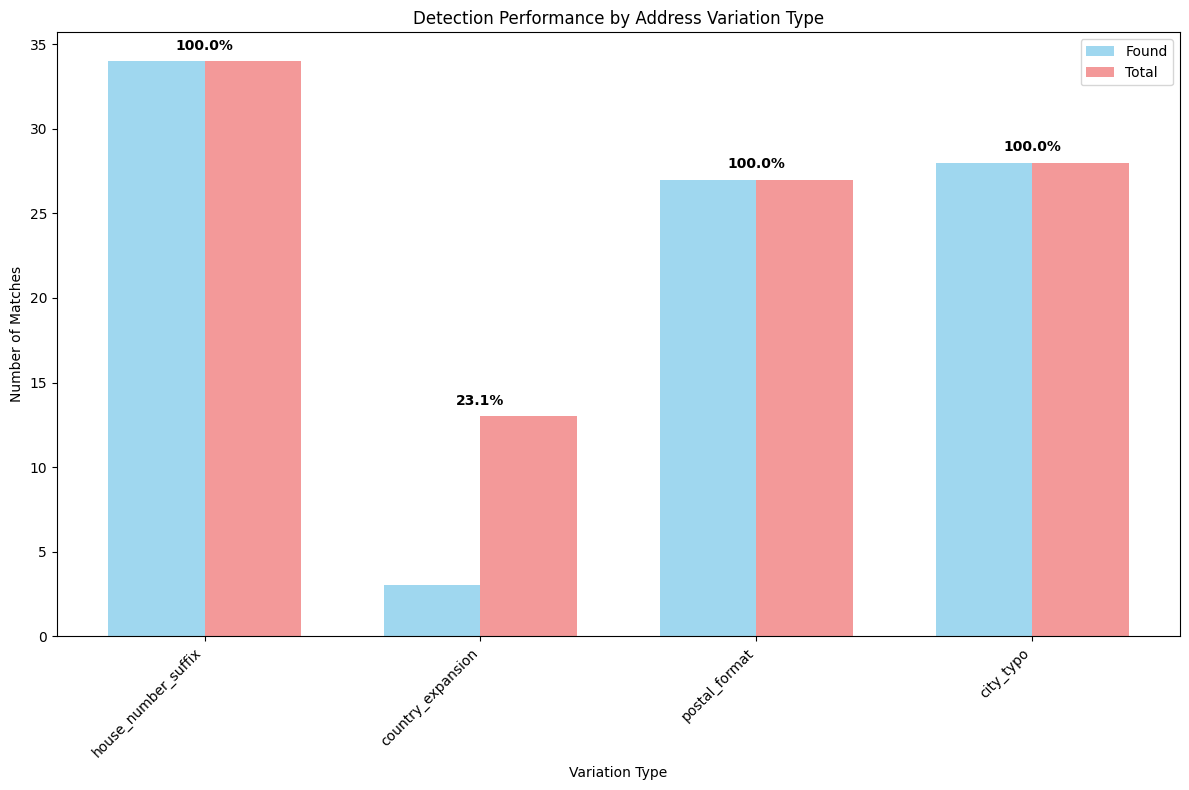

Detection Results by Address Variation Type:
--------------------------------------------------
house_number_suffix       |  34/ 34 (100.0%)
country_expansion         |   3/ 13 ( 23.1%)
postal_format             |  27/ 27 (100.0%)
city_typo                 |  28/ 28 (100.0%)
--------------------------------------------------
Overall                   |  92/102 ( 90.2%)


In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the golden standard data
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Replace entity types to match your test data format
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

# Filter for Address entities
address_variations = golden_standard[golden_standard['entity_type'] == 'Address']

# Create a mapping from ID pairs to variation types
address_variation_lookup = {}
for _, row in address_variations.iterrows():
    key = (row['original_id'], row['duplicate_id'])
    address_variation_lookup[key] = row['variation_type']

# 'found' should be a set of tuples like ('id1', 'id2') for Address
# If you have 'extracted_pairs' and 'golden_pairs' for Address, do:
# found = extracted_pairs & golden_pairs

found_with_variation = {}
for pair in found:
    if pair in address_variation_lookup:
        var_type = address_variation_lookup[pair]
        if var_type not in found_with_variation:
            found_with_variation[var_type] = 0
        found_with_variation[var_type] += 1

# Calculate totals for each variation type
variation_totals = {}
for var_type in address_variations['variation_type'].unique():
    variation_totals[var_type] = len(address_variations[address_variations['variation_type'] == var_type])

# Prepare data for plotting
variation_types = list(variation_totals.keys())
found_counts = [found_with_variation.get(vt, 0) for vt in variation_types]
total_counts = [variation_totals[vt] for vt in variation_types]

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(variation_types))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], found_counts, width, label='Found', alpha=0.8, color='skyblue')
bars2 = ax.bar([i + width/2 for i in x], total_counts, width, label='Total', alpha=0.8, color='lightcoral')

# Add percentage labels on bars
for i, (found, total) in enumerate(zip(found_counts, total_counts)):
    percentage = (found / total * 100) if total > 0 else 0
    ax.text(i, max(found, total) + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Variation Type')
ax.set_ylabel('Number of Matches')
ax.set_title('Detection Performance by Address Variation Type')
ax.set_xticks(x)
ax.set_xticklabels(variation_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results
print("Detection Results by Address Variation Type:")
print("-" * 50)
for var_type in variation_types:
    found_count = found_with_variation.get(var_type, 0)
    total_count = variation_totals[var_type]
    percentage = (found_count / total_count * 100) if total_count > 0 else 0
    print(f"{var_type:25} | {found_count:3d}/{total_count:3d} ({percentage:5.1f}%)")

print("-" * 50)
total_found = sum(found_counts)
total_possible = sum(total_counts)
overall_percentage = (total_found / total_possible * 100) if total_possible > 0 else 0
print(f"{'Overall':25} | {total_found:3d}/{total_possible:3d} ({overall_percentage:5.1f}%)")

In [45]:
golden_pairs

{('02299f58-9071-414d-b4f2-ba8e32fa6380',
  '9879da72-a05a-4068-9847-764592f88d11'),
 ('022c88c0-b563-446c-9cbf-0c64c039c71e',
  '679dbeb2-2136-402b-811b-c2471abca0b2'),
 ('054efa50-4962-473b-a0f9-986ab2363b7e',
  'e1e2e652-9338-43f7-a2fd-f109bc809bb5'),
 ('055c64dd-e478-40a6-9368-e0d60b46b634',
  '723dbbdc-7c06-484f-981f-c83194cb02f1'),
 ('09fa0833-e2fe-46d1-8b64-acd73331cc05',
  'c62939fe-115f-4356-aea6-1517caa5bfda'),
 ('0e1cae7a-8122-4b3a-a0b8-024401e32354',
  '8df92f88-8f1d-454f-b67e-7f142fd94075'),
 ('0e8cff18-9e9d-4b77-ba34-b580eda0a0af',
  'b43baeb2-62b1-4c36-99a2-e67258cf1235'),
 ('100cfe80-2132-4c24-81b3-77bd59eae69a',
  '17c81b33-341f-40eb-8766-b0a5676d41fd'),
 ('1095e497-3d79-4f0b-a6cd-3595d4f0d65d',
  '679dbeb2-2136-402b-811b-c2471abca0b2'),
 ('19d5f970-98b3-4c6e-8a14-b90a7795e986',
  '7b63c53e-6b9f-42e4-8f88-e955994d36b8'),
 ('1ae3237f-aa88-4965-9654-7b4d317588ff',
  'bd4cf3d7-3c27-4645-99bd-a9a62e2d500a'),
 ('1ba43eaf-84f4-4346-9301-6d9e87d3b238',
  '7429dbf7-cf0f-4899-a

In [47]:
extracted_pairs

{('02299f58-9071-414d-b4f2-ba8e32fa6380',
  '9879da72-a05a-4068-9847-764592f88d11'),
 ('022c88c0-b563-446c-9cbf-0c64c039c71e',
  'aa028d76-59a1-44aa-8472-1575b08b7116'),
 ('054efa50-4962-473b-a0f9-986ab2363b7e',
  'e1e2e652-9338-43f7-a2fd-f109bc809bb5'),
 ('055c64dd-e478-40a6-9368-e0d60b46b634',
  '723dbbdc-7c06-484f-981f-c83194cb02f1'),
 ('09fa0833-e2fe-46d1-8b64-acd73331cc05',
  'c62939fe-115f-4356-aea6-1517caa5bfda'),
 ('0e1cae7a-8122-4b3a-a0b8-024401e32354',
  '8df92f88-8f1d-454f-b67e-7f142fd94075'),
 ('0e8cff18-9e9d-4b77-ba34-b580eda0a0af',
  'b43baeb2-62b1-4c36-99a2-e67258cf1235'),
 ('100cfe80-2132-4c24-81b3-77bd59eae69a',
  '17c81b33-341f-40eb-8766-b0a5676d41fd'),
 ('1095e497-3d79-4f0b-a6cd-3595d4f0d65d',
  '679dbeb2-2136-402b-811b-c2471abca0b2'),
 ('15f82b2f-bc89-4faf-8cf4-627782dcf736',
  '0f42b4b1-ce65-4801-a2a6-8f3ae05b8cd1'),
 ('19d5f970-98b3-4c6e-8a14-b90a7795e986',
  '7b63c53e-6b9f-42e4-8f88-e955994d36b8'),
 ('1ae3237f-aa88-4965-9654-7b4d317588ff',
  'bd4cf3d7-3c27-4645-9

In [37]:
extracted_pairs

{('02299f58-9071-414d-b4f2-ba8e32fa6380',
  '9879da72-a05a-4068-9847-764592f88d11'),
 ('022c88c0-b563-446c-9cbf-0c64c039c71e',
  'aa028d76-59a1-44aa-8472-1575b08b7116'),
 ('054efa50-4962-473b-a0f9-986ab2363b7e',
  'e1e2e652-9338-43f7-a2fd-f109bc809bb5'),
 ('055c64dd-e478-40a6-9368-e0d60b46b634',
  '723dbbdc-7c06-484f-981f-c83194cb02f1'),
 ('09fa0833-e2fe-46d1-8b64-acd73331cc05',
  'c62939fe-115f-4356-aea6-1517caa5bfda'),
 ('0e1cae7a-8122-4b3a-a0b8-024401e32354',
  '8df92f88-8f1d-454f-b67e-7f142fd94075'),
 ('0e8cff18-9e9d-4b77-ba34-b580eda0a0af',
  'b43baeb2-62b1-4c36-99a2-e67258cf1235'),
 ('100cfe80-2132-4c24-81b3-77bd59eae69a',
  '17c81b33-341f-40eb-8766-b0a5676d41fd'),
 ('1095e497-3d79-4f0b-a6cd-3595d4f0d65d',
  '679dbeb2-2136-402b-811b-c2471abca0b2'),
 ('15f82b2f-bc89-4faf-8cf4-627782dcf736',
  '0f42b4b1-ce65-4801-a2a6-8f3ae05b8cd1'),
 ('19d5f970-98b3-4c6e-8a14-b90a7795e986',
  '7b63c53e-6b9f-42e4-8f88-e955994d36b8'),
 ('1ae3237f-aa88-4965-9654-7b4d317588ff',
  'bd4cf3d7-3c27-4645-9

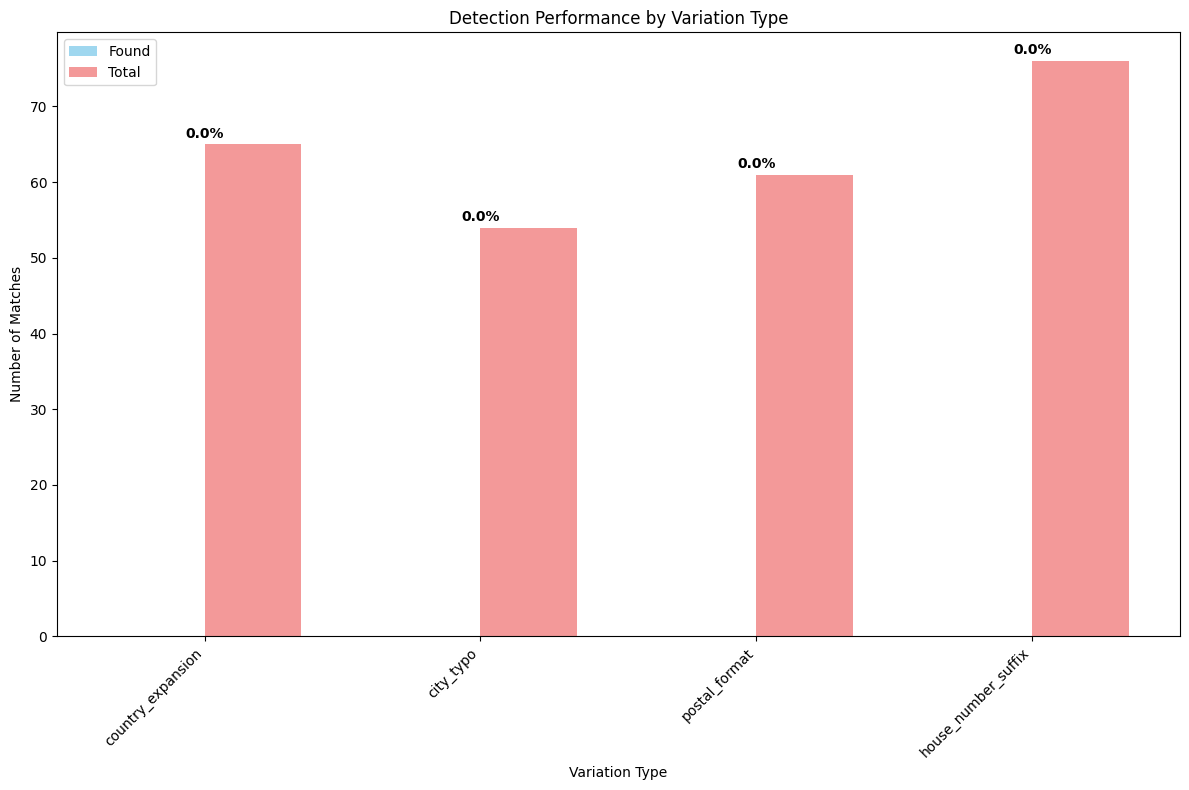

Detection Results by Variation Type:
--------------------------------------------------
country_expansion         |   0/ 65 (  0.0%)
city_typo                 |   0/ 54 (  0.0%)
postal_format             |   0/ 61 (  0.0%)
house_number_suffix       |   0/ 76 (  0.0%)
--------------------------------------------------
Overall                   |   0/256 (  0.0%)


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the golden standard data
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Replace entity types to match your test data format
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

# Filter for Person entities (including HealthcarePersonnel)
person_variations = golden_standard[
    (golden_standard['entity_type'] == 'Person') | 
    (golden_standard['entity_type'] == 'HealthcarePersonnel')
]

# Create a mapping from ID pairs to variation types
variation_lookup = {}
for _, row in person_variations.iterrows():
    key = (row['original_id'], row['duplicate_id'])
    variation_lookup[key] = row['variation_type']

# Convert your found results back to ID pairs
# Assuming 'found' contains tuples like ('id1', 'id2')
found_with_variation = {}

for pair in found:
    if pair in variation_lookup:
        var_type = variation_lookup[pair]
        if var_type not in found_with_variation:
            found_with_variation[var_type] = 0
        found_with_variation[var_type] += 1

# Calculate totals for each variation type
variation_totals = {}
for var_type in address_variations['variation_type'].unique():
    variation_totals[var_type] = len(address_variations[address_variations['variation_type'] == var_type])

# Prepare data for plotting
variation_types = list(variation_totals.keys())
found_counts = [found_with_variation.get(vt, 0) for vt in variation_types]
total_counts = [variation_totals[vt] for vt in variation_types]

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(variation_types))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], found_counts, width, label='Found', alpha=0.8, color='skyblue')
bars2 = ax.bar([i + width/2 for i in x], total_counts, width, label='Total', alpha=0.8, color='lightcoral')

# Add percentage labels on bars
for i, (found, total) in enumerate(zip(found_counts, total_counts)):
    percentage = (found / total * 100) if total > 0 else 0
    ax.text(i, max(found, total) + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Variation Type')
ax.set_ylabel('Number of Matches')
ax.set_title('Detection Performance by Variation Type')
ax.set_xticks(x)
ax.set_xticklabels(variation_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results
print("Detection Results by Variation Type:")
print("-" * 50)
for var_type in variation_types:
    found_count = found_with_variation.get(var_type, 0)
    total_count = variation_totals[var_type]
    percentage = (found_count / total_count * 100) if total_count > 0 else 0
    print(f"{var_type:25} | {found_count:3d}/{total_count:3d} ({percentage:5.1f}%)")

print("-" * 50)
total_found = sum(found_counts)
total_possible = sum(total_counts)
overall_percentage = (total_found / total_possible * 100) if total_possible > 0 else 0
print(f"{'Overall':25} | {total_found:3d}/{total_possible:3d} ({overall_percentage:5.1f}%)")

In [ ]:
pip install "numpy>=1.23

Note: you may need to restart the kernel to use updated packages.
